This is the English-language version of the EDA. The dataset is significantly smaller than the Indonesian one, so some distributions may look less smooth. The patterns here reflect reviews from users who chose to write in English, which skews toward a certain user profile.

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df_text = pd.read_csv("../csv/jago_preprocessing_en.csv")

# Load date from raw data
df_raw = pd.read_csv("../csv/jago_reviews_raw.csv", usecols=["reviewId", "at"])
df_text = df_text.merge(df_raw, on="reviewId", how="left")
df_text["at"] = pd.to_datetime(df_text["at"])

In [17]:
from langdetect import detect

def detect_lang(text):
    try:
        return detect(str(text))
    except:
        return "unknown"

# Detect language of each review
df_text["lang"] = df_text["content"].apply(detect_lang)

# Filter English-only reviews
df_text = df_text[df_text["lang"] == "en"].reset_index(drop=True)

print(f"Total English-only reviews: {len(df_text)}")
print(df_text["sentiment"].value_counts())

Total English-only reviews: 2169
sentiment
positive    1448
negative     721
Name: count, dtype: int64


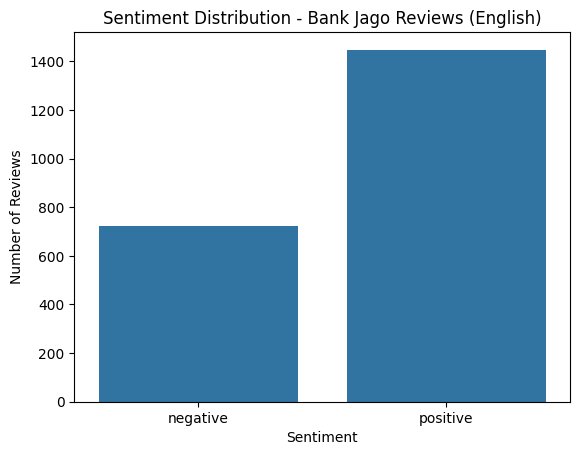

In [18]:
sns.countplot(data=df_text, x="sentiment")
plt.title("Sentiment Distribution - Bank Jago Reviews (English)")
plt.xlabel("Sentiment")
plt.ylabel("Number of Reviews")
plt.show()

With fewer data points, the class imbalance problem is more visible here than in the Indonesian version. Keep this in mind when interpreting model performance on the English dataset later.

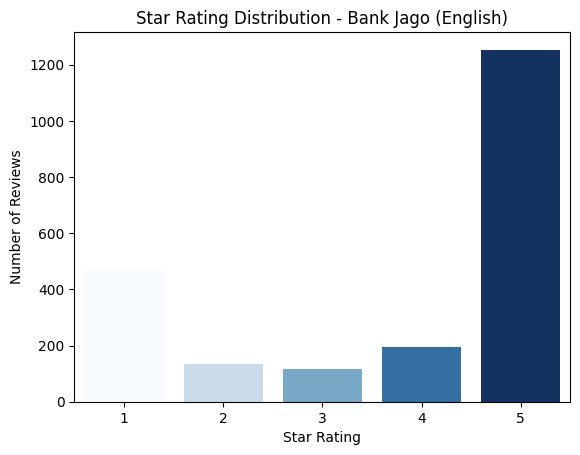

In [19]:
# Star rating distribution
sns.countplot(data=df_text, x="score", hue="score", palette="Blues", legend=False)
plt.title("Star Rating Distribution - Bank Jago (English)")
plt.xlabel("Star Rating")
plt.ylabel("Number of Reviews")
plt.show()

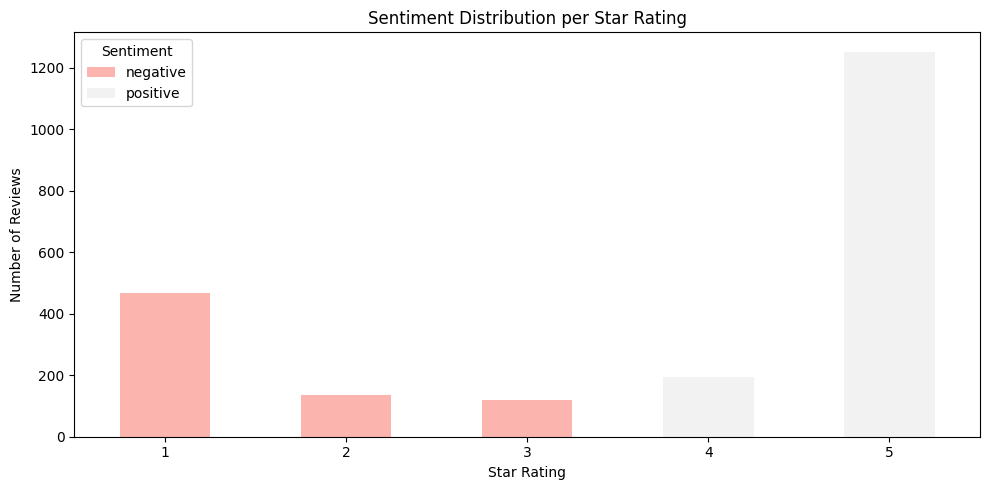

In [20]:
ct = pd.crosstab(df_text["score"], df_text["sentiment"])
ct.plot(kind="bar", stacked=True, colormap="Pastel1", figsize=(10, 5))
plt.title("Sentiment Distribution per Star Rating")
plt.xlabel("Star Rating")
plt.ylabel("Number of Reviews")
plt.xticks(rotation=0)
plt.legend(title="Sentiment")
plt.tight_layout()
plt.show()

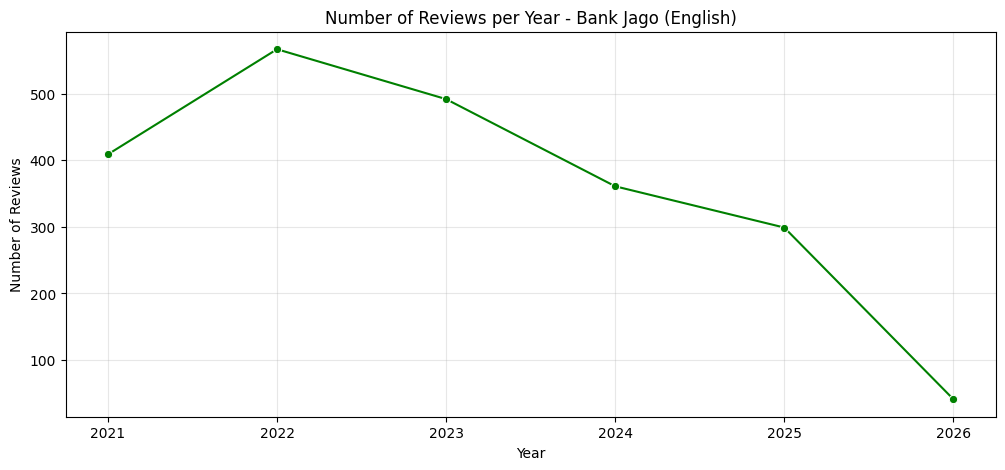

In [21]:
df_text["year"] = df_text["at"].dt.year

# Number of reviews per year
year_counts = df_text["year"].value_counts().sort_index()
plt.figure(figsize=(12, 5))
sns.lineplot(x=year_counts.index, y=year_counts.values, marker="o", color="green")
plt.title("Number of Reviews per Year - Bank Jago (English)")
plt.xlabel("Year")
plt.ylabel("Number of Reviews")
plt.grid(True, alpha=0.3)
plt.show()

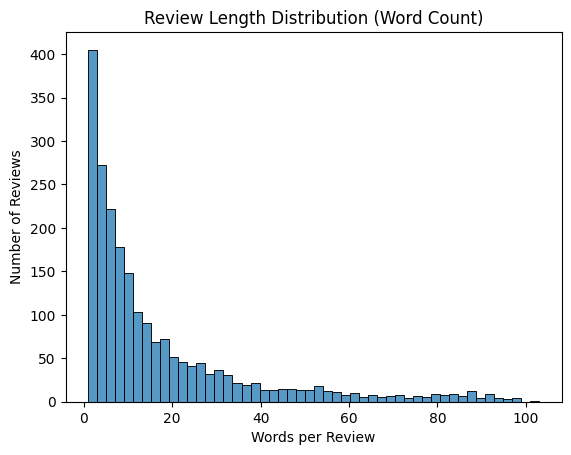

In [22]:
df_text["review_length"] = df_text["clean_text"].fillna("").str.split().apply(len)

sns.histplot(df_text["review_length"], bins=50)
plt.title("Review Length Distribution (Word Count)")
plt.xlabel("Words per Review")
plt.ylabel("Number of Reviews")
plt.show()

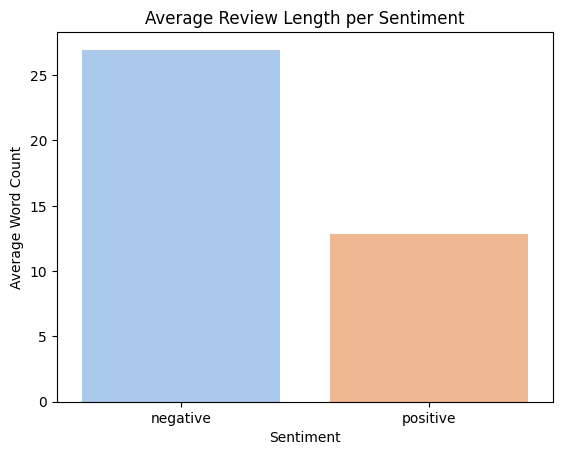

In [23]:
avg_length = df_text.groupby("sentiment")["review_length"].mean().reset_index()
sns.barplot(data=avg_length, x="sentiment", y="review_length",
            hue="sentiment", palette="pastel", legend=False)
plt.title("Average Review Length per Sentiment")
plt.xlabel("Sentiment")
plt.ylabel("Average Word Count")
plt.show()

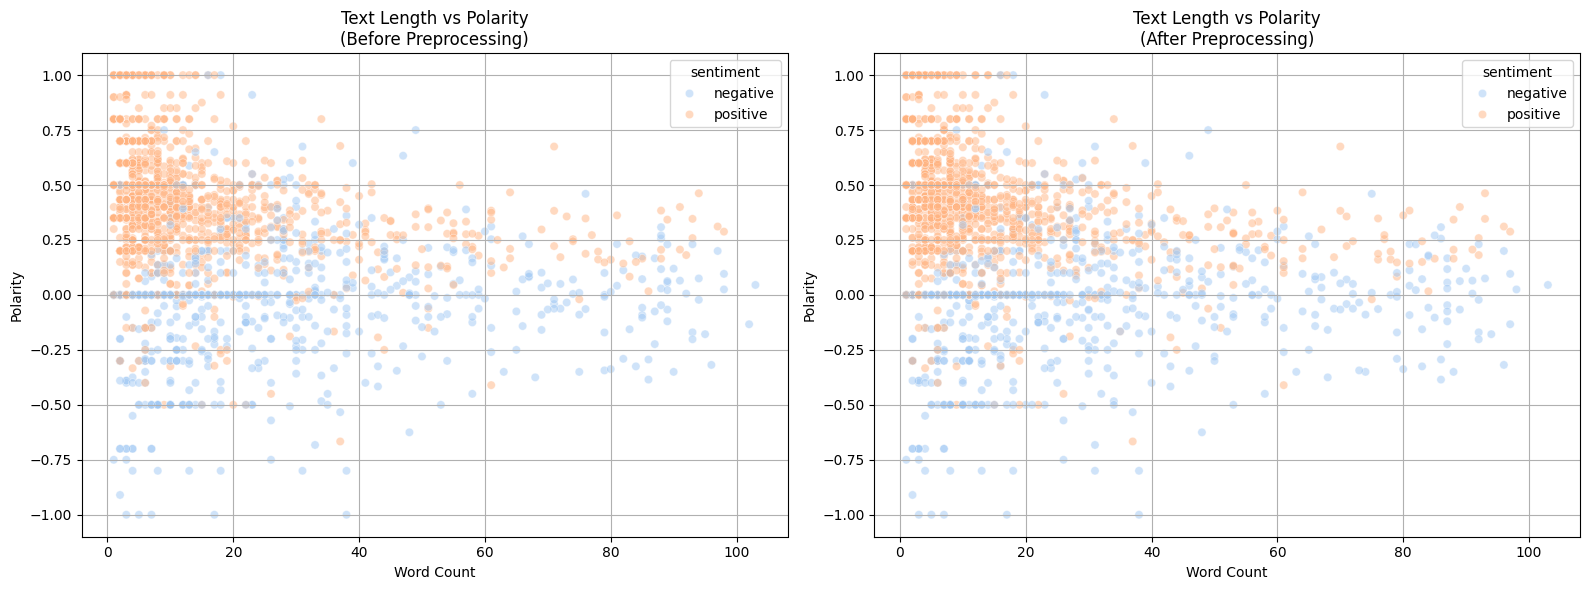

In [24]:
from textblob import TextBlob

df_text["original_length"] = df_text["content"].fillna("").str.split().apply(len)
df_text["clean_length"] = df_text["clean_text"].fillna("").str.split().apply(len)
df_text["polarity"] = df_text["clean_text"].fillna("").apply(
    lambda x: TextBlob(str(x)).sentiment.polarity
)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.scatterplot(data=df_text, ax=axes[0],
    x="original_length", y="polarity",
    hue="sentiment", palette="pastel", alpha=0.5)
axes[0].set_title("Text Length vs Polarity\n(Before Preprocessing)")
axes[0].set_xlabel("Word Count")
axes[0].set_ylabel("Polarity")
axes[0].grid(True)

sns.scatterplot(data=df_text, ax=axes[1],
    x="clean_length", y="polarity",
    hue="sentiment", palette="pastel", alpha=0.5)
axes[1].set_title("Text Length vs Polarity\n(After Preprocessing)")
axes[1].set_xlabel("Word Count")
axes[1].set_ylabel("Polarity")
axes[1].grid(True)

plt.tight_layout()
plt.show()

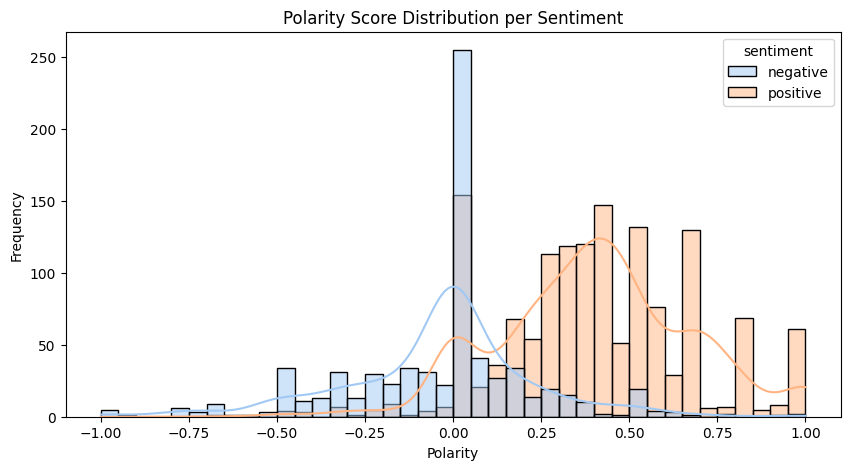

In [25]:
plt.figure(figsize=(10, 5))
sns.histplot(data=df_text, x="polarity", hue="sentiment",
             bins=40, kde=True, palette="pastel")
plt.title("Polarity Score Distribution per Sentiment")
plt.xlabel("Polarity")
plt.ylabel("Frequency")
plt.show()

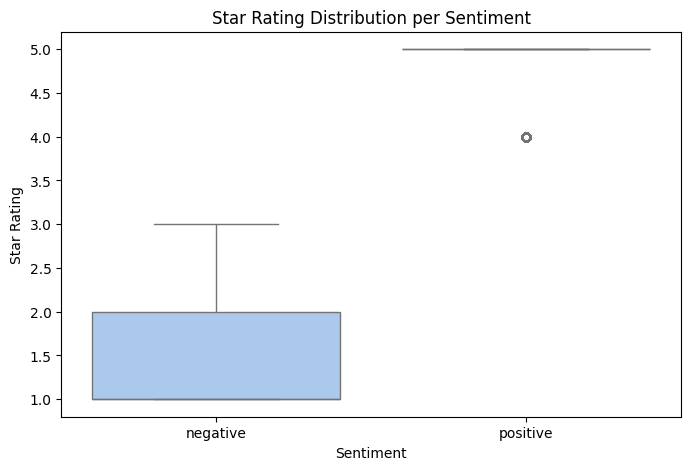

In [26]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=df_text, x="sentiment", y="score",
            hue="sentiment", palette="pastel", legend=False)
plt.title("Star Rating Distribution per Sentiment")
plt.xlabel("Sentiment")
plt.ylabel("Star Rating")
plt.show()

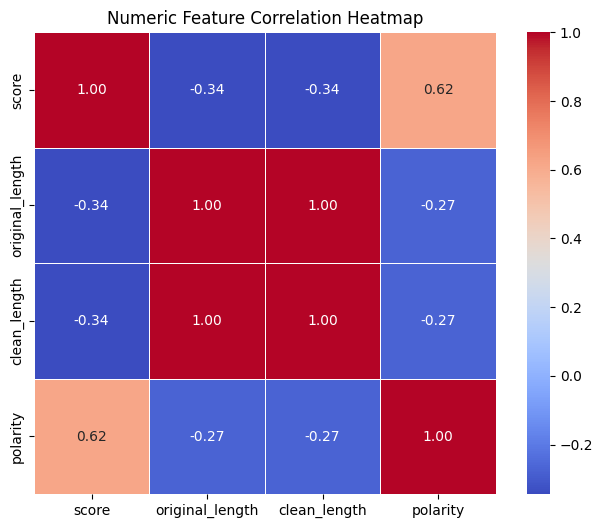

In [27]:
# Relevant numeric columns
num_cols = ["score", "original_length", "clean_length", "polarity"]
corr = df_text[num_cols].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True, linewidths=0.5)
plt.title("Numeric Feature Correlation Heatmap")
plt.show()

In [28]:
from collections import Counter
import nltk
from nltk.corpus import stopwords

nltk.download("stopwords", quiet=True)
stop_en = set(stopwords.words("english"))

# Tokenize clean_text and remove stopwords
df_text["tokens"] = df_text["clean_text"].fillna("").apply(
    lambda x: [w for w in x.split() if w not in stop_en and len(w) > 1]
)

# Separate tokens by sentiment
neg_tokens = df_text[df_text["sentiment"] == "negative"]["tokens"].sum()
pos_tokens = df_text[df_text["sentiment"] == "positive"]["tokens"].sum()

# Top 20 most frequent words
top_neg = Counter(neg_tokens).most_common(20)
top_pos = Counter(pos_tokens).most_common(20)

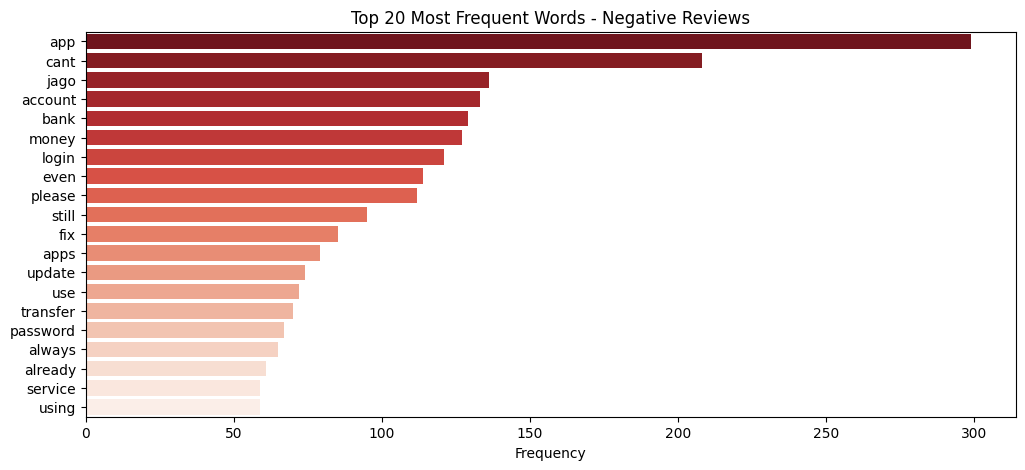

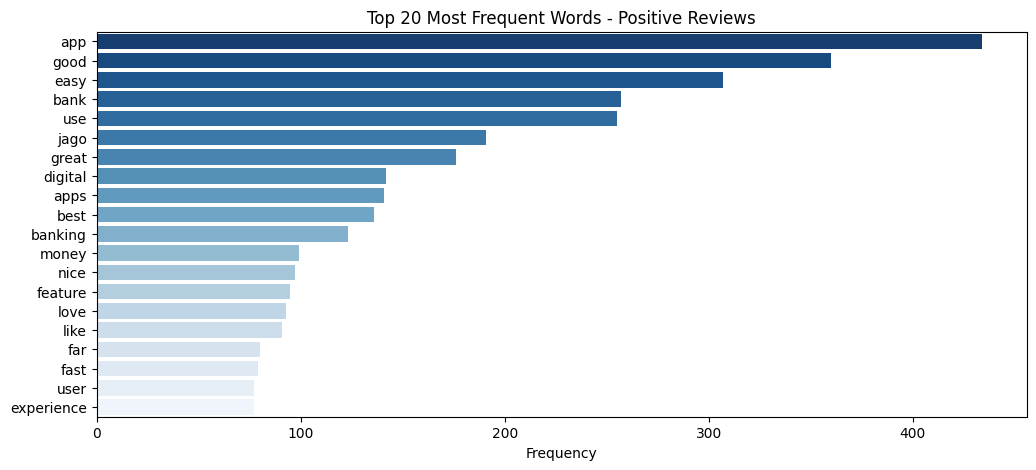

In [29]:
# Bar chart most frequent words - NEGATIVE
words_neg, counts_neg = zip(*top_neg)
plt.figure(figsize=(12, 5))
sns.barplot(x=list(counts_neg), y=list(words_neg),
            hue=list(words_neg), palette="Reds_r", legend=False)
plt.title("Top 20 Most Frequent Words - Negative Reviews")
plt.xlabel("Frequency")
plt.show()

# Bar chart most frequent words - POSITIVE
words_pos, counts_pos = zip(*top_pos)
plt.figure(figsize=(12, 5))
sns.barplot(x=list(counts_pos), y=list(words_pos),
            hue=list(words_pos), palette="Blues_r", legend=False)
plt.title("Top 20 Most Frequent Words - Positive Reviews")
plt.xlabel("Frequency")
plt.show()

If Indonesian words appear here (like "bank", "jago", "tidak"), it means the CSV still contains mixed-language reviews. Add a language filter at the top of this notebook using `langdetect` or by filtering on the `lang` column from the raw data.

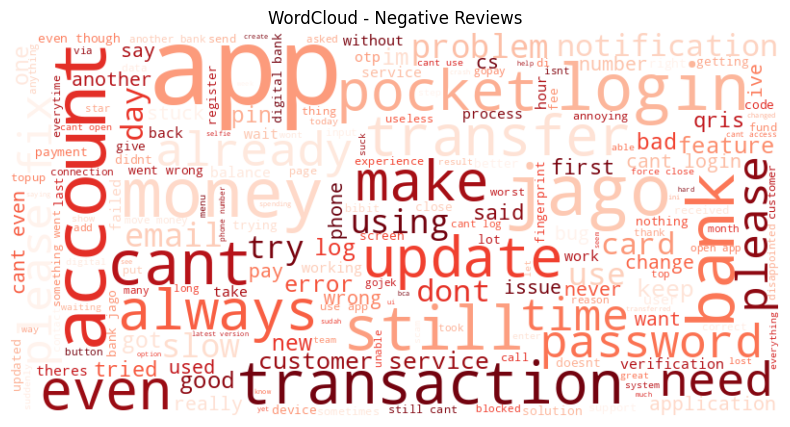

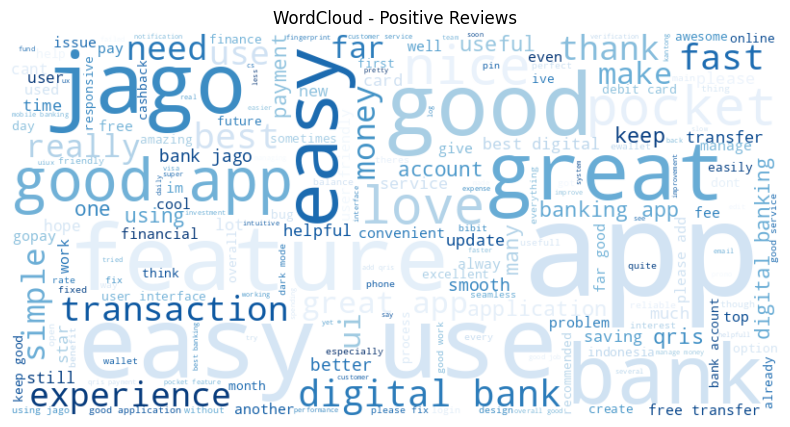

In [30]:
from wordcloud import WordCloud

# WordCloud Negative
neg_text = " ".join(neg_tokens)
wc_neg = WordCloud(width=800, height=400, background_color="white",
                   colormap="Reds").generate(neg_text)
plt.figure(figsize=(10, 5))
plt.imshow(wc_neg, interpolation="bilinear")
plt.axis("off")
plt.title("WordCloud - Negative Reviews")
plt.show()

# WordCloud Positive
pos_text = " ".join(pos_tokens)
wc_pos = WordCloud(width=800, height=400, background_color="white",
                   colormap="Blues").generate(pos_text)
plt.figure(figsize=(10, 5))
plt.imshow(wc_pos, interpolation="bilinear")
plt.axis("off")
plt.title("WordCloud - Positive Reviews")
plt.show()

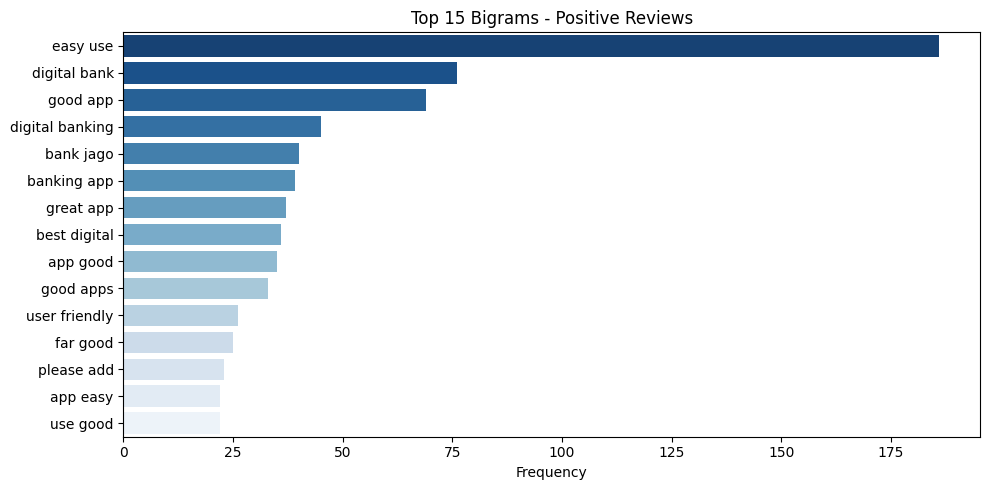

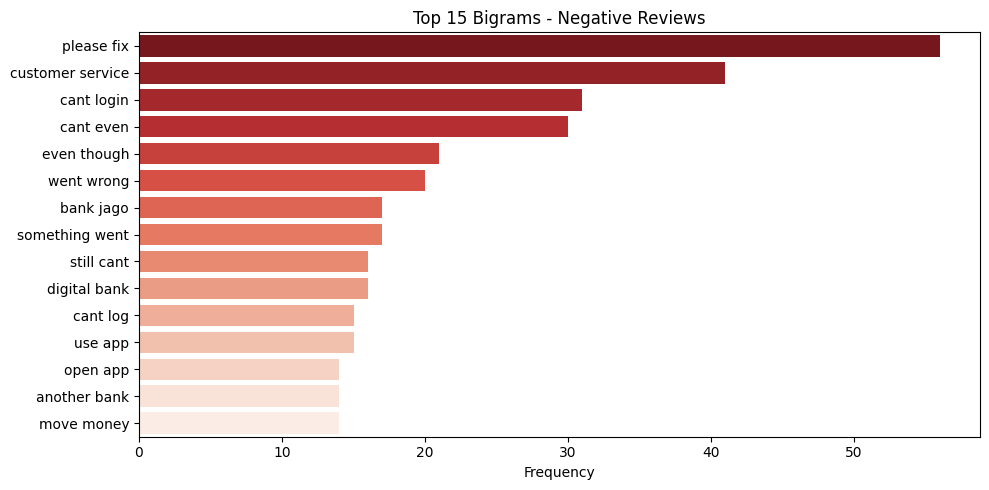

In [31]:
from nltk import bigrams
from collections import Counter

# Bigram Positive
pos_bigrams = list(bigrams(pos_tokens))
top_pos_bigrams = Counter(pos_bigrams).most_common(15)
bg_words, bg_counts = zip(*[(" ".join(b), c) for b, c in top_pos_bigrams])

plt.figure(figsize=(10, 5))
sns.barplot(x=list(bg_counts), y=list(bg_words),
            hue=list(bg_words), palette="Blues_r", legend=False)
plt.title("Top 15 Bigrams - Positive Reviews")
plt.xlabel("Frequency")
plt.tight_layout()
plt.show()

# Bigram Negative
neg_bigrams = list(bigrams(neg_tokens))
top_neg_bigrams = Counter(neg_bigrams).most_common(15)
bg_words_n, bg_counts_n = zip(*[(" ".join(b), c) for b, c in top_neg_bigrams])

plt.figure(figsize=(10, 5))
sns.barplot(x=list(bg_counts_n), y=list(bg_words_n),
            hue=list(bg_words_n), palette="Reds_r", legend=False)
plt.title("Top 15 Bigrams - Negative Reviews")
plt.xlabel("Frequency")
plt.tight_layout()
plt.show()